In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [59]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')

In [60]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [61]:
print(len(data))

1048575


In [62]:
data.isnull().values.any()

True

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [64]:
data.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [65]:
print(data['Sentence #'].nunique())
print(data.Word.nunique())
print(data.Tag.nunique())   

47959
35177
17


In [66]:
print(data.groupby('Tag').size().reset_index(name='count'))

      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [67]:
df = data.fillna(method='ffill')
df.head()

/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1230/309189052.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [68]:
df.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [69]:
print(df.isnull().values.any())

False


In [70]:
# 단어 소문자 처리
df['Word'] = df['Word'].str.lower()
print(df['Word'].nunique()) # 35177에서 줄어든 모습

31817


In [71]:
func = lambda temp : [(w,t) for w, t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]
tagged_sentences = [t for t in df.groupby('Sentence #').apply(func)]

print(len(tagged_sentences))

47959


/var/folders/mr/zpw8mcz14pj_gkyqs4k_zl4c0000gn/T/ipykernel_1230/3389811469.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tagged_sentences = [t for t in df.groupby('Sentence #').apply(func)]


In [72]:
print(tagged_sentences[47958])

[('the', 'O'), ('united', 'B-org'), ('nations', 'I-org'), ('is', 'O'), ('praising', 'O'), ('the', 'O'), ('use', 'O'), ('of', 'O'), ('military', 'O'), ('helicopters', 'O'), ('to', 'O'), ('drop', 'O'), ('food', 'O'), ('and', 'O'), ('rescue', 'O'), ('survivors', 'O'), ('in', 'O'), ('tsunami-ravaged', 'B-tim'), ('indonesia', 'I-tim'), (',', 'O'), ('saying', 'O'), ('the', 'O'), ('aircraft', 'O'), ('are', 'O'), ('"', 'O'), ('worth', 'O'), ('their', 'O'), ('weight', 'O'), ('in', 'O'), ('gold', 'O'), ('.', 'O'), ('"', 'O')]


In [73]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [74]:
print(sentences[0],'\n', ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.'] 
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [75]:
print('최대 길이 : ', max(len(l) for l in sentences))
print('평균 길이 : ', sum(map(len, sentences))/len(sentences))

최대 길이 :  104
평균 길이 :  21.863987989741236


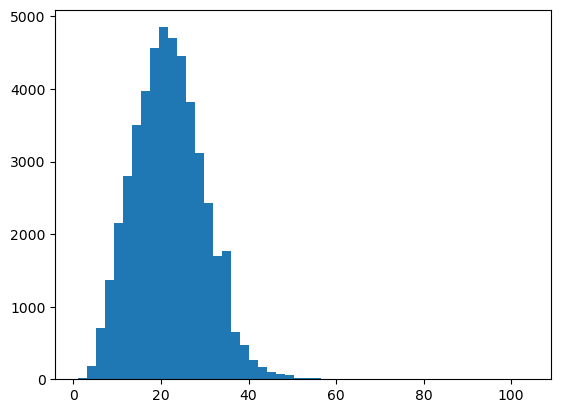

In [76]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [77]:
src_tokenizer = Tokenizer() # 모든 단어를 사용하여 토큰화 (인덱스 1에는 OOV를 할당)
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태킹 정보들을 대문자 유지
tar_tokenizer.fit_on_texts(ner_tags)

In [78]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : ', vocab_size)
print('태깅 집합의 크기 : ', tag_size)

단어 집합의 크기 :  31818
태깅 집합의 크기 :  18


In [79]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [80]:
print(X_data[0], y_data[0])

[253, 5, 966, 15, 1794, 237, 467, 6, 522, 1, 128, 4, 60, 8, 570, 1, 832, 5, 185, 89, 21, 14, 55, 2] [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [81]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word

In [82]:
print(index_to_word)

{1: 'the', 2: '.', 3: ',', 4: 'in', 5: 'of', 6: 'to', 7: 'a', 8: 'and', 9: "'s", 10: 'for', 11: 'has', 12: 'on', 13: 'is', 14: 'that', 15: 'have', 16: 'with', 17: 'said', 18: 'was', 19: 'at', 20: 'says', 21: 'from', 22: 'by', 23: 'he', 24: 'an', 25: 'as', 26: 'say', 27: 'u.s.', 28: 'it', 29: 'are', 30: '"', 31: 'were', 32: 'his', 33: 'will', 34: 'president', 35: 'officials', 36: 'government', 37: 'mr.', 38: 'been', 39: 'killed', 40: 'two', 41: 'people', 42: 'after', 43: 'not', 44: 'its', 45: 'be', 46: 'but', 47: 'they', 48: 'more', 49: 'also', 50: 'new', 51: 'united', 52: 'military', 53: 'who', 54: 'last', 55: 'country', 56: 'than', 57: 'minister', 58: 'police', 59: 'their', 60: 'iraq', 61: 'one', 62: 'which', 63: 'security', 64: 'this', 65: 'about', 66: 'year', 67: 'other', 68: 'had', 69: 'states', 70: 'least', 71: 'tuesday', 72: 'since', 73: 'forces', 74: 'world', 75: 'thursday', 76: 'week', 77: 'group', 78: 'iran', 79: 'over', 80: 'state', 81: 'friday', 82: 'monday', 83: 'wednesday'

In [83]:
index_to_word[0] = '<PAD>'

In [84]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat'}


In [85]:
decoded = []

for index in X_data[0]:
    decoded.append(index_to_word[index])

print(sentences[0])
print(decoded)

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [86]:
max_len = 60

X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [87]:
print(X_data.shape, y_data.shape)

(47959, 60) (47959, 60)


In [88]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [89]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [90]:
print(X_train.shape, y_train_int.shape, y_train.shape)
print(X_test.shape, y_test_int.shape, y_test.shape)

(38367, 60) (38367, 60) (38367, 60, 18)
(9592, 60) (9592, 60) (9592, 60, 18)


In [91]:
words = list(set(df['Word'].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


In [92]:
char_to_index = {c : i+2 for i, c in enumerate(chars)}
char_to_index['OOV'] = 1
char_to_index['PAD'] = 0

In [93]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [94]:
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [95]:
print(char_to_index)

{'!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '?': 28, '@': 29, '[': 30, ']': 31, '_': 32, '`': 33, 'a': 34, 'b': 35, 'c': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 'i': 42, 'j': 43, 'k': 44, 'l': 45, 'm': 46, 'n': 47, 'o': 48, 'p': 49, 'q': 50, 'r': 51, 's': 52, 't': 53, 'u': 54, 'v': 55, 'w': 56, 'x': 57, 'y': 58, 'z': 59, '~': 60, '\x85': 61, '\x91': 62, '\x92': 63, '\x93': 64, '\x94': 65, '\x96': 66, '\x97': 67, '\xa0': 68, '°': 69, 'é': 70, 'ë': 71, 'ö': 72, 'ü': 73, 'OOV': 1, 'PAD': 0}


In [96]:
max_len_char = 15

def padding_char_indice(char_indice, max_len_char): # 문자끼리의 길이
    return pad_sequences(char_indice, maxlen = max_len_char, padding='post', value=0)

def integer_coding(sentences): # 단어 리스트로 이루어진 문장들의 리스트
    char_data = []
    for ts in sentences: # 단어 리스트
        word_indice = [word_to_index[t] for t in ts] # 각 단어 정수로 변환
        char_indice = [[char_to_index[char] for char in t] for t in ts] # 각 단어의 문자들을 정수로 변환
        char_indice = padding_char_indice(char_indice, max_len_char) # 문자 기준 인덱스 리스트 패딩

        for chars_of_token in char_indice:
            if len(chars_of_token) > max_len_char:
                continue

        char_data.append(char_indice)

    return char_data

In [97]:
X_char_data = integer_coding(sentences)

In [98]:
print(X_data[0])

[ 253    5  966   15 1794  237  467    6  522    1  128    4   60    8
  570    1  832    5  185   89   21   14   55    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [99]:
print(X_char_data[0])

[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0  0  0  0  0  0

In [100]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value=0) # 단어 기준 패딩

In [101]:
X_char_data[0]

array([[53, 41, 48, 54, 52, 34, 47, 37, 52,  0,  0,  0,  0,  0,  0],
       [48, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37, 38, 46, 48, 47, 52, 53, 51, 34, 53, 48, 51, 52,  0,  0],
       [41, 34, 55, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [46, 34, 51, 36, 41, 38, 37,  0,  0,  0,  0,  0,  0,  0,  0],
       [53, 41, 51, 48, 54, 40, 41,  0,  0,  0,  0,  0,  0,  0,  0],
       [45, 48, 47, 37, 48, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [53, 48,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [49, 51, 48, 53, 38, 52, 53,  0,  0,  0,  0,  0,  0,  0,  0],
       [53, 41, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [56, 34, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [42, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [42, 51, 34, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [34, 47, 37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37, 38, 46, 34, 47, 37,  0

In [102]:
X_train_char, X_test_char, _, _ = train_test_split(X_char_data, y_data, test_size=0.2, random_state=42)

In [103]:
X_train_char = np.array(X_train_char)
X_test_char = np.array(X_test_char)

In [104]:
print(X_train_char[0])

[[52 48 54 53 41  0  0  0  0  0  0  0  0  0  0]
 [44 48 51 38 34  0  0  0  0  0  0  0  0  0  0]
 [ 8 52  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [40 48 55 38 51 47 46 38 47 53  0  0  0  0  0]
 [53 54 38 52 37 34 58  0  0  0  0  0  0  0  0]
 [34 45 52 48  0  0  0  0  0  0  0  0  0  0  0]
 [54 47 55 38 42 45 38 37  0  0  0  0  0  0  0]
 [34  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [52 48 13 36 34 45 45 38 37  0  0  0  0  0  0]
 [40 51 38 38 47  0  0  0  0  0  0  0  0  0  0]
 [47 38 56  0  0  0  0  0  0  0  0  0  0  0  0]
 [43 48 35  0  0  0  0  0  0  0  0  0  0  0  0]
 [36 51 38 34 53 42 48 47  0  0  0  0  0  0  0]
 [49 45 34 47  0  0  0  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [38 57 49 38 36 53 38 37  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [36 51 38 34 53 38  0  0  0  0  0  0  0  0  0]
 [25 12 22 16 12 16 16 16  0  0  0  0  0  0  0]
 [47 38 56  0  0  0  0  0  0  0  0  0  0  0  0]
 [43 48 35 52  0  0  0  0  0  0  0  0  0

In [105]:
print(index_to_word[100])

first


In [106]:
print(X_train_char[0][0])

[52 48 54 53 41  0  0  0  0  0  0  0  0  0  0]


In [107]:
print(' '.join([index_to_char[index] for index in X_train_char[0][0]]))

s o u t h PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [108]:
print(X_train.shape, X_train_char.shape)
print(X_test.shape, X_test_char.shape)
print(y_train.shape, y_test.shape)

(38367, 60) (38367, 60, 15)
(9592, 60) (9592, 60, 15)
(38367, 60, 18) (9592, 60, 18)


In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [110]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         4072704   
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 512)         788480    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, None, 18)          9234      
 stributed)                                                      
                                                                 
Total params: 4870418 (18.58 MB)
Trainable params: 4870418 (18.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
es = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode='max', verbose=1, save_best_only=True)

In [130]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.1, callbacks=[es, mc])



Epoch 1/10
270/270 [==============================] - ETA: 0s - loss: 0.0498 - acc: 0.9854
Epoch 1: val_acc improved from -inf to 0.98373, saving model to best_model.h5
270/270 [==============================] - 268s 989ms/step - loss: 0.0498 - acc: 0.9854 - val_loss: 0.0556 - val_acc: 0.9837
Epoch 2/10


/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - ETA: 0s - loss: 0.0378 - acc: 0.9885
Epoch 2: val_acc improved from 0.98373 to 0.98426, saving model to best_model.h5
270/270 [==============================] - 247s 914ms/step - loss: 0.0378 - acc: 0.9885 - val_loss: 0.0535 - val_acc: 0.9843
Epoch 3/10
270/270 [==============================] - ETA: 0s - loss: 0.0314 - acc: 0.9902
Epoch 3: val_acc improved from 0.98426 to 0.98450, saving model to best_model.h5
270/270 [==============================] - 267s 988ms/step - loss: 0.0314 - acc: 0.9902 - val_loss: 0.0546 - val_acc: 0.9845
Epoch 4/10
270/270 [==============================] - ETA: 0s - loss: 0.0271 - acc: 0.9915
Epoch 4: val_acc did not improve from 0.98450
270/270 [==============================] - 159s 587ms/step - loss: 0.0271 - acc: 0.9915 - val_loss: 0.0566 - val_acc: 0.9843
Epoch 5/10
270/270 [==============================] - ETA: 0s - loss: 0.0237 - acc: 0.9924
Epoch 5: val_acc did not improve from 0.98450
270/270 [=========

In [131]:
print('test acc : ', model.evaluate(X_test, y_test)[1])

300/300 [==============================] - 22s 73ms/step - loss: 0.0582 - acc: 0.9850
test acc :  0.9850031137466431


In [132]:
i = 30

y_pred = model.predict(np.array([X_test[i])))
y_pred = np.argmax(y_pred, axis=1)
true = np.argmax(y_test[i], -1)

print('{:15}|{:5}|{}'.format('단어', '실제값', '예측값'))
print('-'*35)

for word, tag, pred in zip(X_test[i], true, y_pred[0]):
    if word != 0:
        print("{:17}|{:7}|{}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (644880938.py, line 3)

In [ ]:
epochs = range(1, len(history history['val_loss']) + 1)

plt. plot(epochs, history. history[ 'loss']) plt. plot(epochs, history history[' val_loss'])
plt. title('model loss') plt.ylabel( 'loss')
plt. xlabel( 'epochs')
plt. legend([ 'train', 'val'])
plt. show

In [ ]:
pip install seqeval

In [ ]:
from segeval metrics import f1_score, classification_report

In [ ]:
def sequences_to_tag (sequences) :
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax (pred)
            temp-append (index_to_ner[pred_index] replace('PAD', '0'))
        result.append (temp)
    
    return result

In [ ]:
y_predicted = model predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification report(test_tags, pred_tags))

In [ ]:
print('F1-score:', f1_score(test_tags, pred_tags))

In [ ]:
from tensorflow.keras.layers import Dropout, concatenate, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import load_model

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratop = 0.2
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None, ), dtype='int32', name='words_input') # 단어 인덱스를 입력
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input) # 임베딩 벡터 변환

# char 임베딩
char_input = Input(shape=(None, max_len_char), name='char_input') # 문자 인덱스를 입력
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, # 각 타입스탭에 임베딩 레이어를 적용
                                           # 임베딩 벡터 초기화 -> 가중치를 더 빠르게 수렴
                                           # 균등분포 : 모든 벡터들이 동일한 분포에서 초기화되어있다.
                                           embeddings_initializer-RandomUniform(minval=0.5, maval=0.5)), # -0.5 ~ 0.5 균등분포 초기화
                                name='char_embedding')(char_input)

dropout = Dropout(dropout_ratio)(embed_char_out)

# Conv1D
conv1d_out = TumeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',  activatoin='tanh', strides=1))(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistribu(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

output = concatenate([words, char])

output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, char_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

In [ ]:
history = model.fit([X_train, X_train_char], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])